# Binned vs. unbinned fits

We compare binned with unbinned fit applied to a toy example of a gaussian signal peak over exponential background.

For one-dimensional data, binned fit are preferred. They are usually considerably faster than an unbinned fit and more numerically stable. For multi-dimensional data, however, an unbinned fit can be faster.

It is a common misconception that binned fits are inherently biased. This idea originates from the past when it was common (at least in particle physics) to fit binned data with the least-squares method, which is indeed biased, see [Dembinski, Schmelling, Waldi, *Application of the Iterated Weighted Least-Squares Fit to counting experiments*, NIM A 940 (2019) 135-141](https://doi.org/10.1016/j.nima.2019.05.086). That bias can be completely avoided, however, if the fit uses the maximum-likelihood method and a Poisson distribution to describe the observed bin contents as a function of the predicted ones, and if the model prediction for a bin content is properly computed by integrating over the model density, instead of computing it from the density at the bin center times the bin width. The cost functions `BinnedNLL` and `ExtendedBinnedNLL` from `iminuit.cost` use the correct calculation.

So there is no need to worry bias, but some information is lost in the binning process - the densities of events inside each bin. This loss can be made negligible by making the bin width small enough. How small the bins have to be depends on the sensitivity of the model parameter on this particular loss of information. In this tutorial we demonstrate this and also demonstrate the difference in run-time of unbinned and binned fits.

**Conclusions:** With only 20 bins, the binned fit reached an accuracy for the signal yield that is comparable to the unbinned fit. With 50 bins, also all shape parameters have uncertainties that are less than 5 % larger than those in the unbinned fit. At the same time, the binned fit is much faster. Even with 200 bins, the binned fit is two orders of magnitude faster than the unbinned fit. In practice, this is a huge difference, 3 seconds vs. 5 minutes.

You can try to run this notebook with a data sample contains less points, then the difference will not be as dramatic.

In [1]:
import numpy as np
from numba_stats import norm, expon
import matplotlib.pyplot as plt
from iminuit import Minuit
from iminuit.cost import ExtendedUnbinnedNLL, ExtendedBinnedNLL
import joblib
from IPython.display import display

In [2]:
# sample size, change this to see how the results of the comparison change
n = 100_000
truth = np.array((1.0, 1.0, 1.0, 0.1, 1.0))

rng = np.random.default_rng(1)
s = rng.normal(truth[2], truth[3], size=int(n * truth[0]))
b = rng.exponential(truth[4], size=int(n * truth[1]))
pts = np.append(s, b)
pts = pts[(pts > 0) & (pts < 2)]

In [3]:
def fit(c):
    m = Minuit(c, s=1, b=1, mu=1, sigma=0.1, tau=1)
    m.limits["s", "b", "sigma", "tau"] = (0, None)
    m.limits["mu"] = (0, 2)
    m.migrad()
    assert m.valid
    return m

In [4]:
def density(x, s, b, mu, sigma, tau):
    xrange = (0, 2)
    s1 = s * n * np.diff(norm.cdf(xrange, mu, sigma))
    b1 = b * n * np.diff(expon.cdf(xrange, 0, tau))
    return s1 + b1, (
        s * n * norm.pdf(x, mu, sigma) + 
        b * n * expon.pdf(x, 0, tau)
    )

m = fit(ExtendedUnbinnedNLL(pts, density))
par_names = [m.params[i].name for i in range(m.npar)]
results = {np.inf: (np.array(m.values), np.array(m.errors), m.fmin.time)}
m

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -4.08e+06                  │              Nfcn = 120              │
│ EDM = 1.25e-05 (Goal: 0.0002)    │            time = 0.6 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s     │   0.995   │   0.004   │            │            │    0    │         │       │
│ 1 │ b     │   1.008   │   0.005   │            │            │    0    │         │       │
│ 2 │ mu    │ 999.3e-3  │  0.4e-3   │            │            │    0    │    2    │       │
│ 3 │ sigma │ 99.21e-3  │  0.34e-3  │            │            │    0    │         │       │
│ 4 │ tau   │   1.002   │   0.007   │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────────────────────────┐
│       │         s         b        mu     sigma       tau │
├───────┼───────────────────────────────────────────────────┤
│     s │  1.32e-05 -4.96e-06 -3.97e-08  2.99e-07 -3.97e-06 │
│     b │ -4.96e-06  2.36e-05  8.26e-10  -4.6e-07  1.96e-05 │
│    mu │ -3.97e-08  8.26e-10  1.46e-07 -5.62e-09 -1.42e-07 │
│ sigma │  2.99e-07  -4.6e-07 -5.62e-09  1.12e-07 -3.62e-07 │
│   tau │ -3.97e-06  1.96e-05 -1.42e-07 -3.62e-07  4.76e-05 │
└───────┴───────────────────────────────────────────────────┘

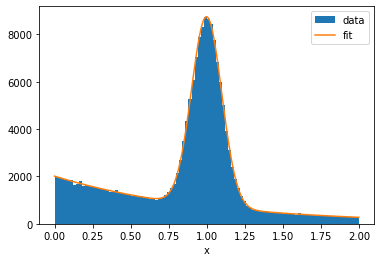

In [5]:
xm = np.linspace(np.min(pts), np.max(pts), 1000)
_, ym = density(xm, *m.values)
plt.hist(pts, bins=100, range=(0, 2), label="data")
dx = 2 / 100
plt.plot(xm, ym * dx, label="fit")
plt.legend()
plt.xlabel("x");

This fit is unbinned, the observed sample is binned here only for visualisation.

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 190.9 (chi2/ndof = 1.0)    │              Nfcn = 110              │
│ EDM = 2.17e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s     │   0.995   │   0.004   │            │            │    0    │         │       │
│ 1 │ b     │   1.008   │   0.005   │            │            │    0    │         │       │
│ 2 │ mu    │ 999.3e-3  │  0.4e-3   │            │            │    0    │    2    │       │
│ 3 │ sigma │ 99.22e-3  │  0.34e-3  │            │            │    0    │         │       │
│ 4 │ tau   │   1.002   │   0.007   │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────────────────────────┐
│       │         s         b        mu     sigma       tau │
├───────┼───────────────────────────────────────────────────┤
│     s │  1.32e-05 -5.01e-06 -3.98e-08  3.02e-07 -4.04e-06 │
│     b │ -5.01e-06  2.37e-05  8.61e-10 -4.66e-07  1.97e-05 │
│    mu │ -3.98e-08  8.61e-10  1.46e-07 -5.93e-09 -1.43e-07 │
│ sigma │  3.02e-07 -4.66e-07 -5.93e-09  1.12e-07 -3.69e-07 │
│   tau │ -4.04e-06  1.97e-05 -1.43e-07 -3.69e-07  4.77e-05 │
└───────┴───────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 87.19 (chi2/ndof = 0.9)    │              Nfcn = 110              │
│ EDM = 2.41e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s     │   0.995   │   0.004   │            │            │    0    │         │       │
│ 1 │ b     │   1.008   │   0.005   │            │            │    0    │         │       │
│ 2 │ mu    │ 999.3e-3  │  0.4e-3   │            │            │    0    │    2    │       │
│ 3 │ sigma │ 99.24e-3  │  0.34e-3  │            │            │    0    │         │       │
│ 4 │ tau   │   1.002   │   0.007   │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────────────────────────┐
│       │         s         b        mu     sigma       tau │
├───────┼───────────────────────────────────────────────────┤
│     s │  1.32e-05 -5.02e-06 -3.97e-08  3.04e-07 -4.05e-06 │
│     b │ -5.02e-06  2.37e-05  4.72e-10 -4.69e-07  1.98e-05 │
│    mu │ -3.97e-08  4.72e-10  1.47e-07 -5.92e-09 -1.44e-07 │
│ sigma │  3.04e-07 -4.69e-07 -5.92e-09  1.13e-07 -3.71e-07 │
│   tau │ -4.05e-06  1.98e-05 -1.44e-07 -3.71e-07  4.78e-05 │
└───────┴───────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 36.34 (chi2/ndof = 0.8)    │              Nfcn = 110              │
│ EDM = 1.7e-06 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s     │   0.995   │   0.004   │            │            │    0    │         │       │
│ 1 │ b     │   1.008   │   0.005   │            │            │    0    │         │       │
│ 2 │ mu    │ 999.3e-3  │  0.4e-3   │            │            │    0    │    2    │       │
│ 3 │ sigma │ 99.20e-3  │  0.34e-3  │            │            │    0    │         │       │
│ 4 │ tau   │   1.002   │   0.007   │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────────────────────────┐
│       │         s         b        mu     sigma       tau │
├───────┼───────────────────────────────────────────────────┤
│     s │  1.32e-05 -5.06e-06 -4.03e-08  3.09e-07 -4.07e-06 │
│     b │ -5.06e-06  2.38e-05  4.56e-10 -4.76e-07  1.98e-05 │
│    mu │ -4.03e-08  4.56e-10  1.48e-07 -6.05e-09 -1.46e-07 │
│ sigma │  3.09e-07 -4.76e-07 -6.05e-09  1.16e-07 -3.77e-07 │
│   tau │ -4.07e-06  1.98e-05 -1.46e-07 -3.77e-07  4.79e-05 │
└───────┴───────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 7.555 (chi2/ndof = 0.5)    │              Nfcn = 102              │
│ EDM = 5.22e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s     │   0.995   │   0.004   │            │            │    0    │         │       │
│ 1 │ b     │   1.008   │   0.005   │            │            │    0    │         │       │
│ 2 │ mu    │ 999.2e-3  │  0.4e-3   │            │            │    0    │    2    │       │
│ 3 │ sigma │  99.5e-3  │  0.4e-3   │            │            │    0    │         │       │
│ 4 │ tau   │   1.002   │   0.007   │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────────────────────────┐
│       │         s         b        mu     sigma       tau │
├───────┼───────────────────────────────────────────────────┤
│     s │  1.34e-05 -5.35e-06 -4.45e-08  3.51e-07 -4.31e-06 │
│     b │ -5.35e-06  2.42e-05 -3.58e-10 -5.42e-07  2.02e-05 │
│    mu │ -4.45e-08 -3.58e-10  1.61e-07 -7.05e-09 -1.64e-07 │
│ sigma │  3.51e-07 -5.42e-07 -7.05e-09  1.37e-07 -4.28e-07 │
│   tau │ -4.31e-06  2.02e-05 -1.64e-07 -4.28e-07  4.83e-05 │
└───────┴───────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.084 (chi2/ndof = 0.4)    │              Nfcn = 114              │
│ EDM = 4.65e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s     │   0.995   │   0.004   │            │            │    0    │         │       │
│ 1 │ b     │   1.007   │   0.005   │            │            │    0    │         │       │
│ 2 │ mu    │ 999.4e-3  │  0.5e-3   │            │            │    0    │    2    │       │
│ 3 │ sigma │  99.8e-3  │  0.7e-3   │            │            │    0    │         │       │
│ 4 │ tau   │   1.003   │   0.007   │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────────────────────────┐
│       │         s         b        mu     sigma       tau │
├───────┼───────────────────────────────────────────────────┤
│     s │  1.54e-05 -8.38e-06 -7.48e-08  1.14e-06 -6.75e-06 │
│     b │ -8.38e-06   2.9e-05  2.17e-08 -1.76e-06  2.43e-05 │
│    mu │ -7.48e-08  2.17e-08  2.06e-07 -2.27e-08 -2.06e-07 │
│ sigma │  1.14e-06 -1.76e-06 -2.27e-08  4.95e-07  -1.4e-06 │
│   tau │ -6.75e-06  2.43e-05 -2.06e-07  -1.4e-06  5.22e-05 │
└───────┴───────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.677e-06                  │              Nfcn = 112              │
│ EDM = 2.68e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s     │   0.996   │   0.005   │            │            │    0    │         │       │
│ 1 │ b     │   1.006   │   0.007   │            │            │    0    │         │       │
│ 2 │ mu    │  0.9998   │  0.0019   │            │            │    0    │    2    │       │
│ 3 │ sigma │  0.1001   │  0.0012   │            │            │    0    │         │       │
│ 4 │ tau   │   1.002   │   0.008   │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────────────────────────┐
│       │         s         b        mu     sigma       tau │
├───────┼───────────────────────────────────────────────────┤
│     s │  2.31e-05 -1.96e-05  -1.6e-06  3.77e-06 -1.41e-05 │
│     b │ -1.96e-05  4.64e-05  5.35e-07  -5.5e-06  3.84e-05 │
│    mu │  -1.6e-06  5.35e-07  3.72e-06 -6.63e-07 -4.19e-06 │
│ sigma │  3.77e-06  -5.5e-06 -6.63e-07   1.4e-06 -3.66e-06 │
│   tau │ -1.41e-05  3.84e-05 -4.19e-06 -3.66e-06  7.03e-05 │
└───────┴───────────────────────────────────────────────────┘

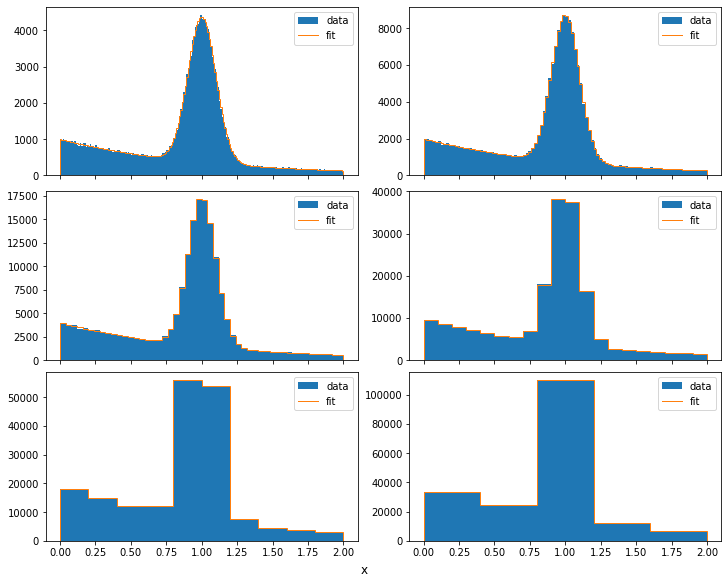

In [6]:
def integral(xe, s, b, mu, sigma, tau):
    return s * n * norm.cdf(xe, mu, sigma) + b * n * expon.cdf(xe, 0, tau)

fig, ax = plt.subplots(3, 2, figsize=(10, 8), sharex=True, constrained_layout=True)
for axi, bins in zip(ax.flat, (200, 100, 50, 20, 10, 5)):
    w, xe = np.histogram(pts, bins=bins, range=(0, 2))
    c = ExtendedBinnedNLL(w, xe, integral)
    m = fit(c)
    display(m)
    axi.stairs(w, xe, fill=True, label="data")
    axi.stairs(np.diff(integral(xe, *m.values)), xe, label="fit")
    axi.legend()
    results[bins] = (np.array(m.values), np.array(m.errors), m.fmin.time)
fig.supxlabel("x");

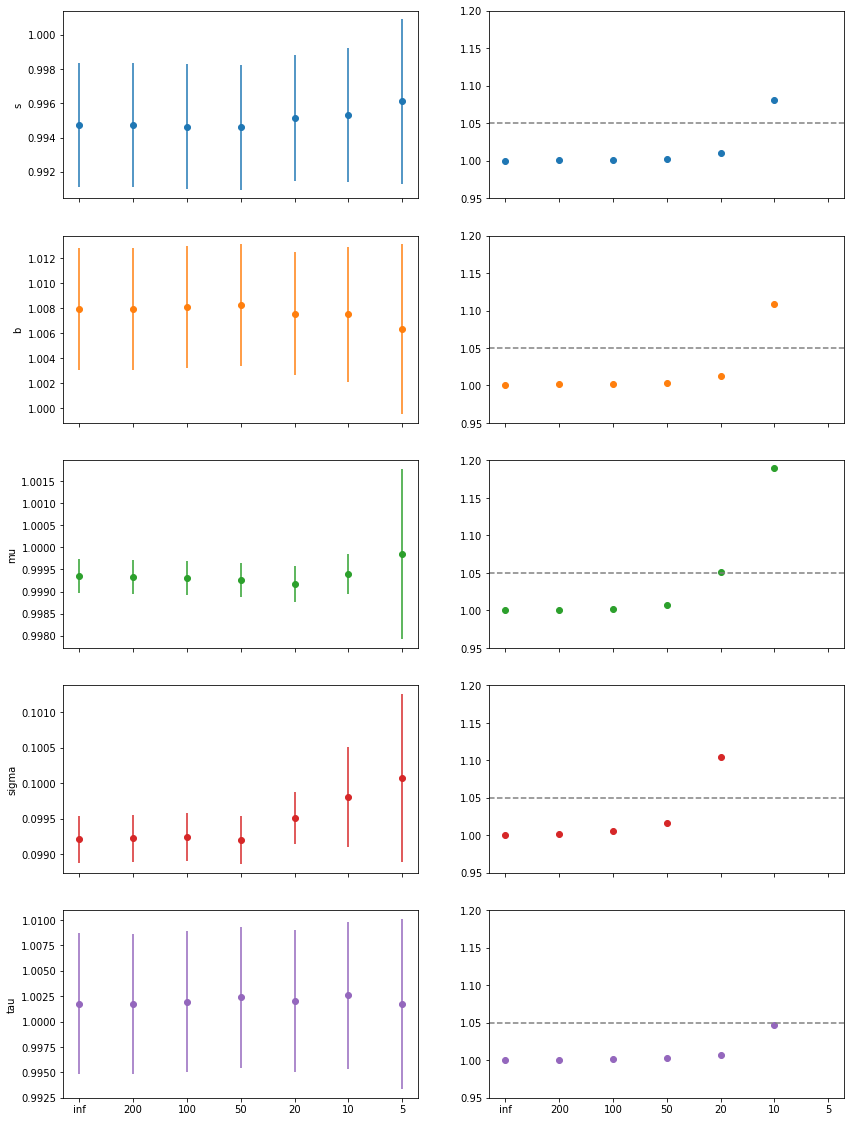

In [7]:
npar = len(results[np.inf][0])

fig, ax = plt.subplots(npar, 2, sharex=True, figsize=(14, 20))
for j, (k, (v, e, _)) in enumerate(results.items()):
    for i, (vi, ei) in enumerate(zip(v, e)):
        c = f"C{i}"
        ax[i, 0].errorbar(j, vi, ei, color=c, fmt="o")
        ax[i, 0].set_ylabel(par_names[i])
        einf = results[np.inf][1][i]
        ax[i, 1].plot(j, ei /einf, "o", color=c)
for i in range(npar):
    ax[i, 1].set_ylim(0.95, 1.2)
    ax[i, 1].axhline(1.05, ls="--", color="0.5")
plt.xticks(np.arange(7), [f"{x}" for x in results.keys()]);

Shown on the left is the fitted value and its uncertainty estimate. Shown of the right is the relative size of the error bar of the binned fit compared to the unbinned fit.

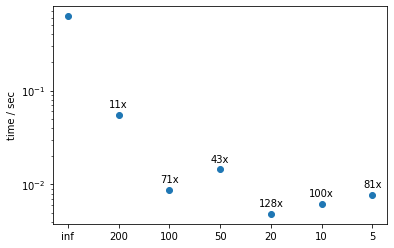

In [8]:
plt.figure()
x = np.arange(7)
y = [v[2] for v in results.values()]
plt.plot(x, y, "o")
for xi, yi in zip(x[1:], y[1:]):
    plt.text(xi, yi * 1.2, f"{y[0]/yi:.0f}x", ha="center")
plt.xticks(x, [f"{x}" for x in results.keys()])
plt.ylabel("time / sec")
plt.semilogy();

We now demonstrate that the binned fits and the unbinned fit are unbiased. We repeat the fit many times with independent random samples, the mean of the results minus the truth is the bias. In each iteration, the binned fits use the same data that the unbinned fit uses.

In [43]:
@joblib.delayed
def run(seed):
    rng = np.random.default_rng(seed)
    s = rng.normal(truth[2], truth[3], size=int(n * truth[0]))
    b = rng.exponential(truth[4], size=int(n * truth[1]))
    pts = np.append(s, b)
    pts = pts[(pts > 0) & (pts < 2)]

    if bins == np.inf:
        m = fit(ExtendedUnbinnedNLL(pts, density))
        assert m.valid
    else:
        w, xe = np.histogram(pts, bins=bins, range=(0, 2))
        m = fit(ExtendedBinnedNLL(w, xe, integral))
        assert m.valid
    return np.array(m.values)

results = {}
for bins in (np.inf, 200, 100, 50, 20, 10, 5):
    results[bins] = joblib.Parallel(-1)(run(seed) for seed in range(100))

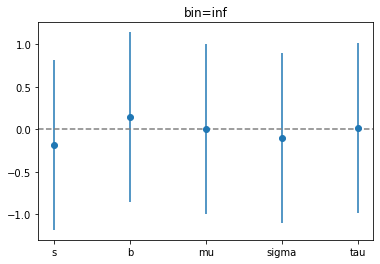

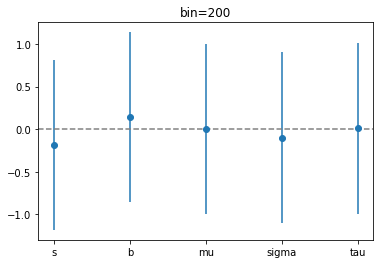

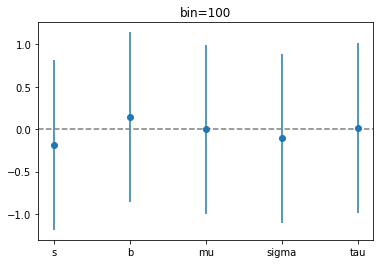

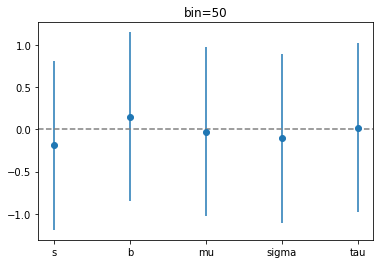

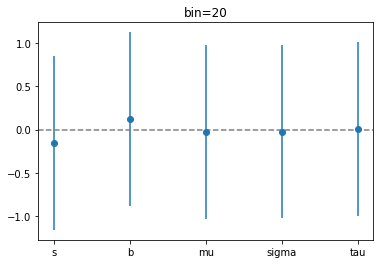

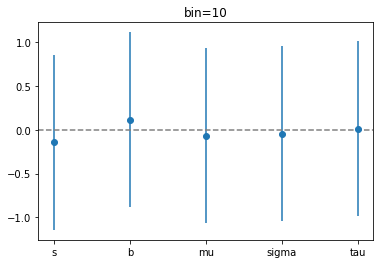

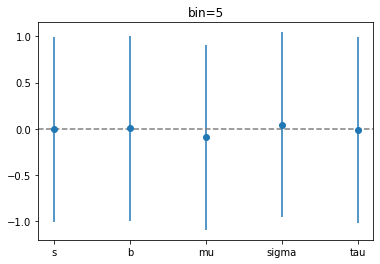

In [46]:
ref = None
for bin, values in results.items():
    plt.figure()
    m = np.mean(values, axis=0) - truth
    s = np.std(values, axis=0, ddof=1)
    plt.title(f"{bin=}")
    plt.errorbar(np.arange(len(m)), m / s, 1, fmt="o", label=f"{bin=}")
    plt.axhline(0, ls="--", color="0.5")
    plt.xticks(np.arange(len(m)), ["s", "b", "mu", "sigma", "tau"]);

The plots show the bias relative to the standard deviation for each parameter. All results are unbiased, whatever the binning. The bias is not exactly zero, since we used only 100 repetitions, it shrinks further with more. One can observe that the residual bias that is coming from the finite sampling is the same for the unbinned fit and the fits with 100 and 200 bins, which are essentially equivalent.